In [1]:
from Architectures.VAE import VAE
from Data.load import load
from matplotlib import pyplot as plt
import numpy as np

In [2]:
train, test = load("Pre-processed", take=-1)

Loading images: 100%|██████████| 496/496 [04:09<00:00,  1.99it/s]


In [3]:
latent_dim = 200
vae = VAE(train.shape,halvings=4, latent_dim=latent_dim, output_activation="tanh",lambda_=1e-5)
vae.compile(loss="mse",optimizer="adam")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 5, 6, 5, 64)



-0.4926044967264753 0.9033169749532135


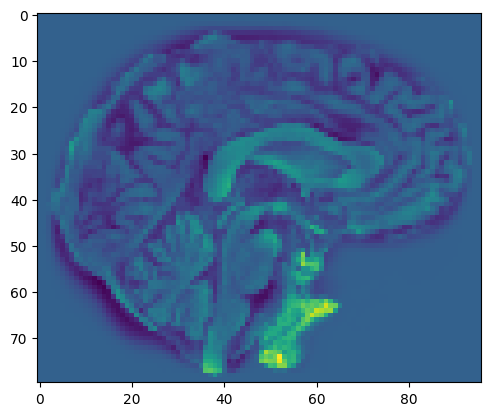

In [8]:
# Train on the diff to the mean brain instead
mean_brain = np.mean(train, axis=0)
diff_train = train - mean_brain
diff_test = test - mean_brain
plt.imshow(np.rot90(diff_train[0][40]))
print(np.min(diff_train), np.max(diff_train))

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling function for the reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

latent_dim = 20
# Define the VAE model
class VAE(keras.Model):
    def __init__(
            self,
            input_shape,
            halvings=4,
            init_hidden_depth=8,
            latent_dim=1_000,
            output_activation="tanh",
            lambda_=1e-5,
            hidden_activation=activations.leaky_relu
            ):
        super(VAE, self).__init__()
        self.lambda_ = lambda_

        shape_changed=False
        if input_shape[-1]>3:
            input_shape = list(input_shape) + [1]
            shape_changed=True
        if len(input_shape)>4:
            input_shape = input_shape[-4:]
            shape_changed=True
        if shape_changed: print(f"Interpreted image shape: {tuple(input_shape)}")

        # Encoder
        encoder_input = x = layers.Input(shape=input_shape)
        depth = init_hidden_depth
        for _ in range(halvings):
            x = layers.Conv3D(depth, (3, 3, 3), strides=2, activation=hidden_activation, padding="same")(x)
            x = layers.Dropout(0.05)(x)
            depth <<= 1

        pre_flatten_shape = x.shape
        print(f"Pre-flattened latent shape: {pre_flatten_shape}")
        x = layers.Flatten()(x)
        
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        
        self.encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(latent_dim,))
        x = layers.Dense(pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4], activation="relu")(decoder_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        
        for _ in range(halvings):
            depth >>= 1
            x = layers.Conv3D(depth, (3, 3, 3), activation=hidden_activation, padding="same")(x)
            x = layers.UpSampling3D((2, 2, 2))(x)
        decoded = layers.Conv3D(1, (3, 3, 3), activation=output_activation, padding="same")(x)
        self.decoder = Model(decoder_input, decoded, name="decoder")
        
    def call(self, inputs):
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
        self.add_loss(kl_loss)
        return reconstructed

# Instantiate the VAE model
vae = VAE(train.shape,latent_dim=latent_dim,halvings=3, lambda_=5e-4)
vae.compile(optimizer=keras.optimizers.Adam(), loss="mse")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 10, 12, 10, 32)


In [4]:
vae.fit(train, train, epochs=20, batch_size=32, verbose=True)
vae.save(f"Trained Models/VAE/{latent_dim}")

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.0793
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0465
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0310
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 996ms/step - loss: 0.0252
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 996ms/step - loss: 0.0231
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0217
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0211
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0211
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0208
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0205
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0204
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0205
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 998ms/step - loss: 0.0203
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0203
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 998ms/step - loss: 0.0201
Epoch 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


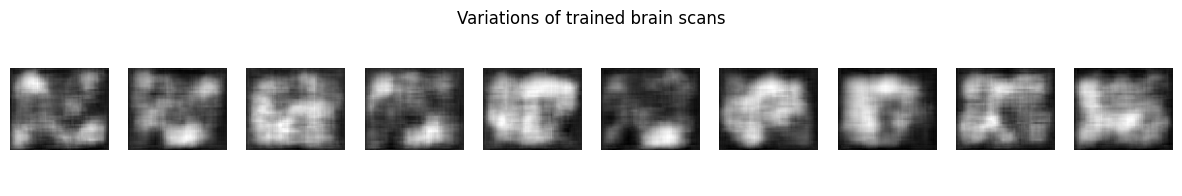

In [5]:
num_samples = 10
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

plt.figure(figsize=(15, 2))
plt.title("Variations of trained brain scans")
plt.axis("off")
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(np.rot90(generated_images[i,40,:,:]), cmap="gray")
    ax.axis("off")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step


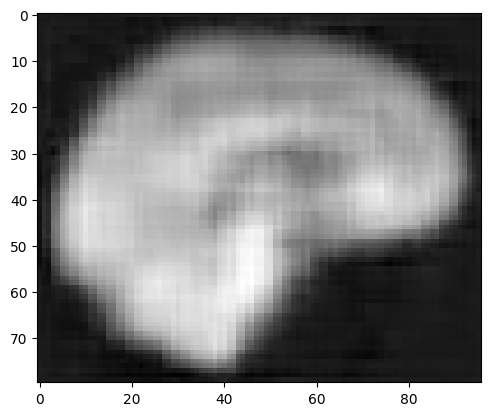

In [6]:
z_mean, z_std, z = vae.encoder.predict(test)
recon = vae.decoder.predict(z_mean)
plt.imshow(np.rot90(recon[0][40]),cmap="gray")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


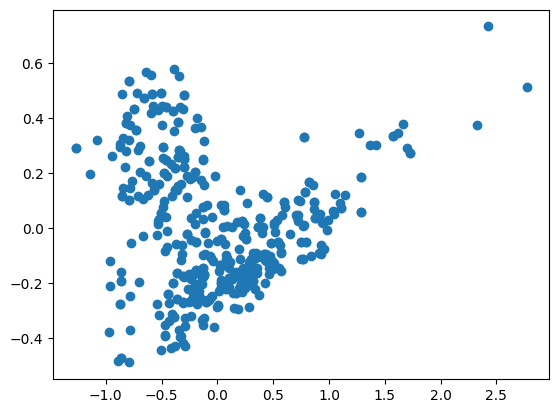

In [7]:
z_mean, z_std, z = vae.encoder.predict(train)
from sklearn.decomposition import PCA
pca = PCA(2)
points = pca.fit_transform(z_mean)
plt.scatter(points[:,0],points[:,1])

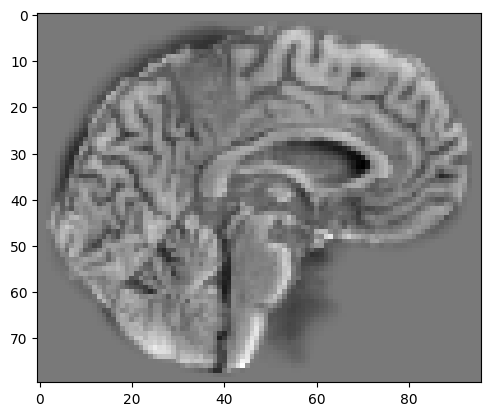

In [57]:
plt.imshow(np.rot90(diff_test[0][40].reshape((96,80))),cmap="gray") # mean_brain[40]+

In [60]:
from Metrics.metrics import NMSE, SSIM
SSIM(recon.reshape(diff_test.shape), diff_test)

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.